In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [9]:
path = '/kaggle/input/store-sales-time-series-forecasting/'
os.listdir(path)

['oil.csv',
 'sample_submission.csv',
 'holidays_events.csv',
 'stores.csv',
 'train.csv',
 'test.csv',
 'transactions.csv']

In [4]:
df_sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
print(df_sample.head())
print(df_sample.shape)

        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
(28512, 2)


In [168]:
# load files
df_train = pd.read_csv(path + 'train.csv', index_col = 0)
df_test = pd.read_csv(path + 'test.csv', index_col = 0)

df_holidays = pd.read_csv(path + 'holidays_events.csv')
df_oil = pd.read_csv(path + 'oil.csv')
df_stores = pd.read_csv(path + 'stores.csv')
df_trans = pd.read_csv(path + 'transactions.csv')

df_subm = pd.read_csv(path + 'sample_submission.csv')

In [15]:
# check dimensions of each file
print(f'Number of train_data samples: {df_train.shape}')
print(f'Number of test_data samples: {df_test.shape}')

print(f'Number of data_oil samples: {df_oil.shape}')
print(f'Number of data_holi samples: {df_holidays.shape}')
print(f'Number of data_store samples: {df_stores.shape}')
print(f'Number of data_trans samples: {df_trans.shape}')

print(f'Number of samp_subm samples: {df_subm.shape}')

Number of train_data samples: (3000888, 6)
Number of test_data samples: (28512, 5)
Number of data_oil samples: (1218, 2)
Number of data_holi samples: (350, 6)
Number of data_store samples: (54, 5)
Number of data_trans samples: (83488, 3)
Number of samp_subm samples: (28512, 2)


In [18]:
# check train data
print(df_train.head())
print(df_train.tail())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
              id        date  store_nbr                      family     sales  \
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  


In [24]:
print(df_train.groupby('date').nunique())

              id  store_nbr  family  sales  onpromotion
date                                                   
2013-01-01  1782         54      33     17            1
2013-01-02  1782         54      33    568            1
2013-01-03  1782         54      33    559            1
2013-01-04  1782         54      33    553            1
2013-01-05  1782         54      33    575            1
...          ...        ...     ...    ...          ...
2017-08-11  1782         54      33    786           73
2017-08-12  1782         54      33    789           55
2017-08-13  1782         54      33    765           67
2017-08-14  1782         54      33    762           54
2017-08-15  1782         54      33    762           75

[1684 rows x 5 columns]


In [145]:
# seems there is some missing date in the train set

grouped = df_train.groupby('date').sum()

# Create a complete date range
full_date_range = pd.date_range(start='2013-01-01', end='2017-08-15')
print(len(full_date_range))

# Find missing dates
present_dates = pd.to_datetime(grouped.index)
# print(present_dates)
missing_dates = pd.Index(full_date_range).difference(present_dates)

# Output missing dates
print("Missing Dates:")
print(missing_dates)
print(len(missing_dates))

# 4 days are missing: 12-25 for every year

1688
Missing Dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)
4


In [19]:
print(df_test.head())
print(df_test.tail())

        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0
            id        date  store_nbr                      family  onpromotion
28507  3029395  2017-08-31          9                     POULTRY            1
28508  3029396  2017-08-31          9              PREPARED FOODS            0
28509  3029397  2017-08-31          9                     PRODUCE            1
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0


In [34]:
# seems there is some missing date in the train set

grouped = df_test.groupby('date').sum()

# Create a complete date range
full_date_range = pd.date_range(start='2017-08-16', end='2017-08-31')

# Find missing dates
present_dates = pd.to_datetime(grouped.index)
# print(present_dates)
missing_dates = pd.Index(full_date_range).difference(present_dates)

# Output missing dates
print("Missing Dates:")
print(missing_dates)
print(len(missing_dates))

# no missing dates for test

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
0


In [20]:
print(df_trans.head())
print(df_trans.tail())

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922
             date  store_nbr  transactions
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802


In [11]:
# check if there is any missing value
df_train.isnull().sum()
# no missing values

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

## Oil price dependency: Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [12]:
print(f"dimention of oil data: {df_oil.shape}")

dimention of oil data: (1218, 2)


In [56]:
print(df_oil.head())

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [35]:
# check empty data in oil
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [54]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [37]:
# There should be 1703 days between 2013-01-01 and 2017-08-31
# But There are lots of missing values and 43 NaN values
len(df_oil.groupby("date").sum())

1218

In [42]:
len(df_oil[df_oil['dcoilwtico'].notnull()])
# 1218 (total numrows) = 1175 (rows with value) + 43 (NaN rows)

1175

In [37]:
df_oil[df_oil['dcoilwtico'] == 0]

,date,dcoilwtico


In [52]:
df_oil[df_oil["date"].isnull()]

,date,dcoilwtico


In [41]:
# sporadic oil missingg values
df_oil[df_oil["dcoilwtico"].isnull()]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


Text(0, 0.5, 'Oil price')

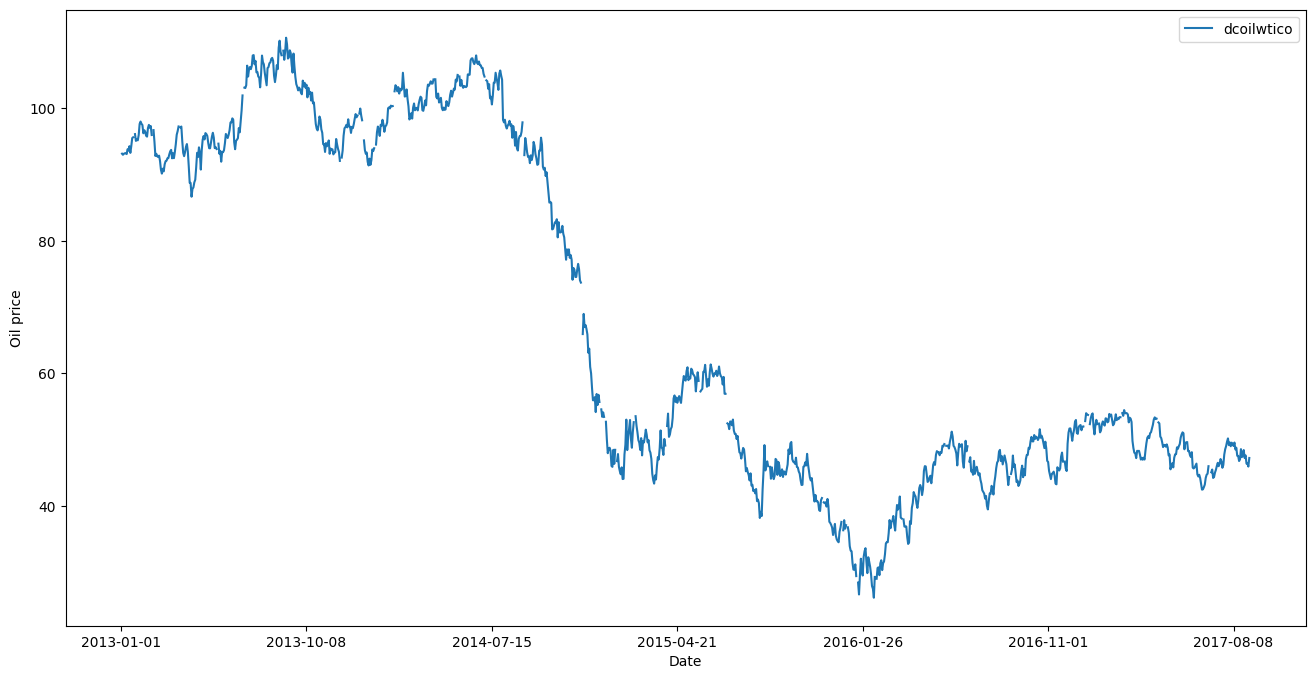

In [23]:
# oil data
ax = df_oil.set_index("date").plot(figsize = (16, 8))
ax.set_xlabel("Date")
ax.set_ylabel("Oil price")

In [62]:
# Import 
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
print(oil.shape)

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
print(oil.shape)

# Replace 0s with NaN
oil = oil.replace(0, np.nan)


(1218, 2)
(1704, 2)


In [119]:
# Import 
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# print(oil.shape)

# print(oil['dcoilwtico'].isnull().sum())

# Fill the first missing value manually
# oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill', limit=1)  # Backward fill the first NaN
# print(oil['dcoilwtico'].isnull().sum())

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum()
# print(oil.shape)

# Replace 0s with NaN
oil = oil.replace(0, np.nan)

# Interpolate and reset index
oil_interpolated = oil.interpolate(method="time").reset_index()

# First value missing: back fill
oil_interpolated['dcoilwtico'] = oil_interpolated['dcoilwtico'].fillna(method='bfill') 

# reset oil index
oil = oil.reset_index()

# Reset index to bring 'date' back as a column
# oil = oil_interpolated.reset_index()
# oil_interpolated.reset_index()

/tmp/ipykernel_30/2334969432.py:23: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [120]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


In [121]:
oil_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


In [122]:
oil_interpolated.head()

,date,dcoilwtico
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [85]:
oil.isnull().sum()

529

In [123]:
oil_interpolated.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [125]:
oil_interpolated.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [127]:
oil_interpolated.rename(columns={'dcoilwtico': 'dcoil_2'}, inplace=True)
oil_interpolated.head()

,date,dcoil_2
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [128]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN


In [138]:
import plotly.express as px

# Merge the DataFrames on the 'date' column
df_merged = pd.merge(oil, oil_interpolated, on='date')

# Melt the merged DataFrame for long format (needed for Plotly)
df_long = df_merged.melt(id_vars='date', 
                         value_vars=['dcoil_2', 'dcoilwtico'], 
                         var_name='Type', 
                         value_name='Value')

# Plot the time series
fig = px.line(df_long, x='date', y='Value', color='Type', 
              title='Original vs Interpolated Time Series',
              labels={'Value': 'Value', 'date': 'Date', 'Type': 'Series Type'},
                 color_discrete_map={
                    'dcoilwtico': 'blue',  # Original series in blue
                    'dcoil_2': 'red'   # Interpolated series in orange
                })

# fig.show()
fig.show(renderer='iframe')

## Does oil price actually affect sales?

In [139]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [147]:
oil_interpolated.head()

,date,dcoil_2
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [142]:
df_train.groupby("date")["sales"].sum()

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [146]:
df = df_train.copy()

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by 'date' and sum sales
sales_per_date = df.groupby('date')['sales'].sum().reset_index()

# Rename columns for clarity (optional)
sales_per_date.rename(columns={'sales': 'total_sales'}, inplace=True)

print(sales_per_date)

           date    total_sales
0    2013-01-01    2511.618999
1    2013-01-02  496092.417944
2    2013-01-03  361461.231124
3    2013-01-04  354459.677093
4    2013-01-05  477350.121229
...         ...            ...
1679 2017-08-11  826373.722022
1680 2017-08-12  792630.535079
1681 2017-08-13  865639.677471
1682 2017-08-14  760922.406081
1683 2017-08-15  762661.935939

[1684 rows x 2 columns]


In [150]:
import plotly.graph_objects as go

# Calculate correlation
correlation = sales_per_date['total_sales'].corr(oil_interpolated['dcoil_2'])
print(f"Correlation between series1 and series2: {correlation:.2f}")


# Create Plotly figure
fig = go.Figure()

# Add Series 1
fig.add_trace(go.Scatter(x=sales_per_date['date'], y=sales_per_date['total_sales'], mode='lines+markers', name='Series 1'))

# Add Series 2
fig.add_trace(go.Scatter(x=oil_interpolated['date'], y=oil_interpolated['dcoil_2'], mode='lines+markers', name='Series 2'))

# Add title with correlation value
fig.update_layout(
    title=f'Time Series Plot (Correlation: {correlation:.2f})',
    xaxis_title='Date',
    yaxis_title='Values',
    legend_title='Series',
    template='plotly_white'
)

fig.show(renderer='iframe')

Correlation between series1 and series2: -0.63


In [155]:
# Merge the DataFrames on the 'date' column
merged_sales_oil = pd.merge(sales_per_date, oil_interpolated, on='date')

# Scatter plot with Plotly
fig = px.scatter(
    merged_sales_oil,
    x='dcoil_2',
    y='total_sales',
    title='Scatter Plot of oil vs sales',
    labels={'dcoil_2': 'oil', 'total_sales': 'sales'},
    template='plotly_white'
)

fig.show(renderer='iframe')

In [156]:
merged_sales_oil.shape

(1684, 3)

## analize Sales

In [161]:
# Plot 
# There seems to be some trend
fig = px.line(
    sales_per_date,
    x='date',
    y='total_sales',
    title='Time Series Plot',
    labels={'date': 'Date', 'total_sales': 'Total Sales'},
    template='plotly_white'
)
fig.show(renderer='iframe')

In [163]:
sales_per_date.isnull().sum()

date           0
total_sales    0
dtype: int64

In [179]:
df_train['id']

KeyError: 'id'

In [ ]:
df_train.head()

In [ ]:
# some stores may not have some family which can lead to 0 sales



In [174]:
df_test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [175]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [18]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
df_stores.shape

(54, 5)

In [30]:
df_transactions.head(-5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83478,2017-08-15,45,3685
83479,2017-08-15,46,3197
83480,2017-08-15,47,3581
83481,2017-08-15,48,2722


In [21]:
df_transactions.shape

(83488, 3)

In [169]:
df_test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [170]:
df_train.head(-5)

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,2017-08-15,9,MEATS,449.228,0
3000880,2017-08-15,9,PERSONAL CARE,522.000,11
